In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf

# seeds
np.random.seed(42)
tf.random.set_seed(42)

# forecast parameters
LAGS = 30
HORIZON = 30

print("GPU:", tf.config.list_physical_devices('GPU'))


GPU: []


In [17]:
import yfinance as yf
df = yf.download("NVDA", start="2010-01-01", end="2024-12-31")
df.head()


/tmp/ipython-input-2327278934.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("NVDA", start="2010-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,
2010-01-04,0.423807,0.426786,0.415097,0.424265,800204000
2010-01-05,0.429995,0.434580,0.422202,0.422202,728648000
2010-01-06,0.432746,0.433663,0.425640,0.429766,649168000
2010-01-07,0.424265,0.432287,0.421056,0.430454,547792000
2010-01-08,0.425182,0.428162,0.418306,0.420827,478168000


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
df = df[['Close']].rename(columns={'Close':'my_close'}).dropna()
df.index = pd.to_datetime(df.index)
#print(df.head())



In [20]:
print(df.columns)
print(df.head())


MultiIndex([('my_close', 'NVDA')],
           names=['Price', 'Ticker'])
Price       my_close
Ticker          NVDA
Date                
2010-01-04  0.423807
2010-01-05  0.429995
2010-01-06  0.432746
2010-01-07  0.424265
2010-01-08  0.425182


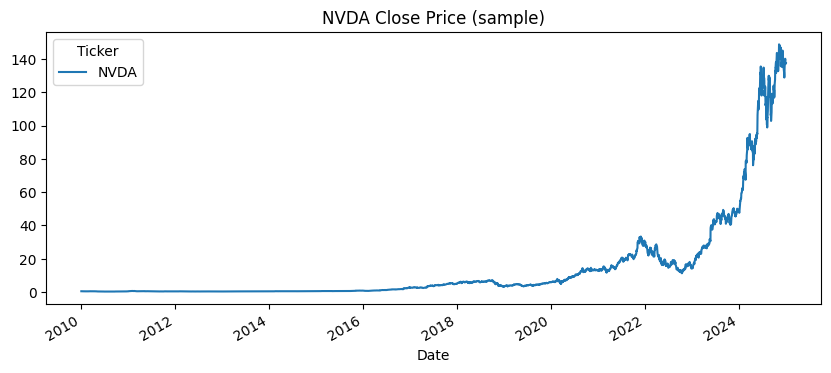

In [21]:
df['my_close'].plot(title='NVDA Close Price (sample)', figsize=(10,4))
plt.show()

Price       my_close  logprice logreturn
Ticker          NVDA                    
Date                                    
2010-01-05  0.429995 -0.843981  0.014497
2010-01-06  0.432746 -0.837605  0.006376
2010-01-07  0.424265 -0.857397 -0.019792
2010-01-08  0.425182 -0.855238  0.002159
2010-01-11  0.419223 -0.869353 -0.014115


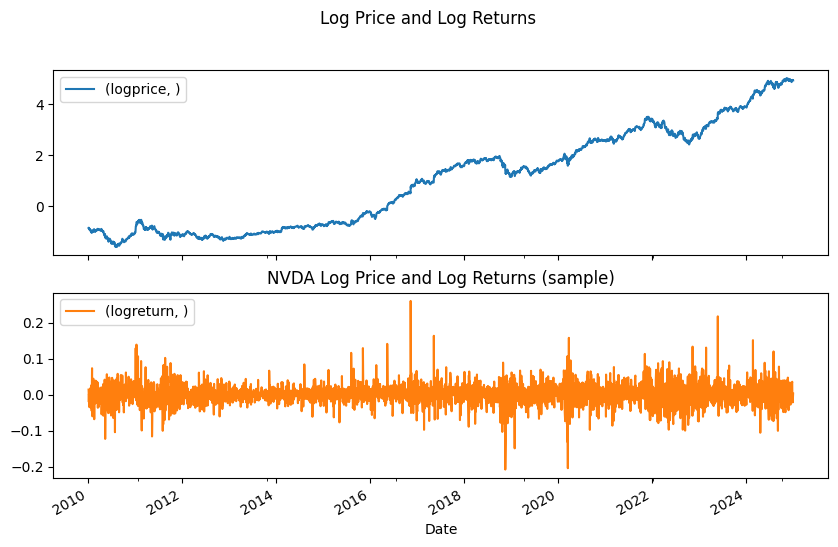

In [22]:
df['logprice'] = np.log(df['my_close'])
df['logreturn'] = df['logprice'].diff() #log returns
df = df.dropna()
print(df[['my_close','logprice','logreturn']].head())
df[['logprice','logreturn']].plot(subplots=True, figsize=(10,6), title='Log Price and Log Returns')
plt.title('NVDA Log Price and Log Returns (sample)')
plt.show()

In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
series = df['logreturn'].values.reshape(-1,1)
series_scaled = scaler.fit_transform(series)
print(series_scaled[:5])

[[ 0.4561973 ]
 [ 0.17043354]
 [-0.75039851]
 [ 0.02203064]
 [-0.55063503]]


In [24]:
def create_supervised(x, lags, horizon):
    X, Y = [], []
    n = len(x)
    for i in range(lags, n - horizon + 1):
        X.append(x[i-lags:i])
        Y.append(x[i:i+horizon].flatten())
    X = np.array(X)
    Y = np.array(Y)
    X = X.reshape((X.shape[0], X.shape[1], 1))  # (samples, lags, 1)
    return X, Y

LAGS, HORIZON = 30, 30
X, Y = create_supervised(series_scaled.flatten(), LAGS, HORIZON)
print("X.shape, Y.shape:", X.shape, Y.shape)



X.shape, Y.shape: (3713, 30, 1) (3713, 30)


In [25]:
split = int(0.8 * len(X))
X_bt, Y_bt = X[:split], Y[:split]


In [29]:
#Backtest iteration
#test residual extraction logic for one window before scaling up.
# pick cut (index in supervised samples)
t_cut = split  # e.g., use previous split
X_bt = X[:t_cut]
Y_bt = Y[:t_cut]

# train small model quickly
bt_model = build_model(LAGS, HORIZON, units=8)
bt_model.fit(X_bt, Y_bt, epochs=5, batch_size=64, verbose=0)

# forecast from sample index forecast_idx
forecast_idx = t_cut - 1  # adjust carefully so you can access Y[forecast_idx]
X_input = X[forecast_idx].reshape(1,LAGS,1)
y_true = Y[forecast_idx]
y_pred_scaled = bt_model.predict(X_input).flatten()
# inverse scale both
y_true_orig = scaler.inverse_transform(y_true.reshape(-1,1)).flatten()
y_pred_orig = scaler.inverse_transform(y_pred_scaled.reshape(-1,1)).flatten()
resid = y_true_orig - y_pred_orig
print("resid shape", resid.shape)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
resid shape (30,)


In [ ]:
#Expand to rolling backtest loop (collect residuals matrix)
#this produces residuals per horizon across many windows — core for dynamic intervals.

residuals_matrix = []

for i in range(len(X_bt)):
    X_input = X_bt[i].reshape(1, LAGS, 1)
    y_true = Y_bt[i]
    y_pred_scaled = bt_model.predict(X_input, verbose=0).flatten()
    y_true_orig = scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()
    y_pred_orig = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    resid = y_true_orig - y_pred_orig
    residuals_matrix.append(resid)

residuals_matrix = np.array(residuals_matrix)
print("residuals_matrix shape:", residuals_matrix.shape)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


q_per_horizon: [0.0369129  0.03699319 0.03697316 0.03689604 0.03694302 0.03699829
 0.0370572  0.03714431 0.03659788 0.03692679 0.03661747 0.03693551
 0.03692661 0.03654444 0.03708356 0.03655695 0.03693711 0.03730571
 0.03684474 0.03713959 0.0368668  0.03674783 0.03681561 0.03717183
 0.03709032 0.03704102 0.03710203 0.03688513 0.0367088  0.03680087]
is non-decreasing-ish (diff >= -tiny_tol)? False


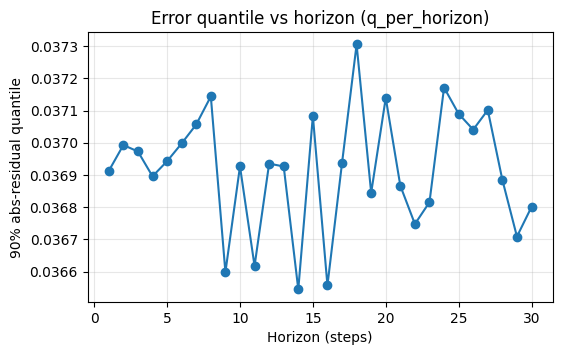

In [30]:
# --- Step 9: quantiles per horizon ---
# residuals_matrix: shape (n_windows, HORIZON)
abs_resid = np.abs(residuals_matrix)       # same shape (n_windows, HORIZON)
alpha = 0.10                               # 90% prediction intervals
q_per_horizon = np.quantile(abs_resid, 1 - alpha, axis=0)  # shape (HORIZON,)

print("q_per_horizon:", q_per_horizon)
print("is non-decreasing-ish (diff >= -tiny_tol)?",
      np.all(np.diff(q_per_horizon) >= -1e-12))  # small negative tolerances OK

# Quick plot: quantile vs horizon
plt.figure(figsize=(6,3.5))
plt.plot(np.arange(1, len(q_per_horizon)+1), q_per_horizon, marker='o')
plt.xlabel("Horizon (steps)")
plt.ylabel(f"{100*(1-alpha):.0f}% abs-residual quantile")
plt.title("Error quantile vs horizon (q_per_horizon)")
plt.grid(alpha=0.3)
plt.show()


In [31]:
final_model = build_model(LAGS, HORIZON, units=32)
final_model.fit(X, Y, epochs=30, batch_size=32, verbose=1)


Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1.0079
Epoch 2/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.0067
Epoch 3/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 1.0066
Epoch 4/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.0065
Epoch 5/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0065
Epoch 6/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0065
Epoch 7/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0064
Epoch 8/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0064
Epoch 9/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0063
Epoch 10/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.0062
Epoch 11/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.0061
Epoch 12/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0059
Epoch 13/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0057
Epoch 14/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0053
Epoch 15/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step 

In [32]:
x_last = X[-1].reshape(1,LAGS,1)
pred_scaled = final_model.predict(x_last).flatten()
pred = scaler.inverse_transform(pred_scaled.reshape(-1,1)).flatten()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


In [33]:
last_log = df['logprice'].iloc[-1]

log_point = last_log + np.cumsum(pred)
log_upper = last_log + np.cumsum(pred + q_per_horizon)
log_lower = last_log + np.cumsum(pred - q_per_horizon)

price_point = np.exp(log_point)
price_upper = np.exp(log_upper)
price_lower = np.exp(log_lower)


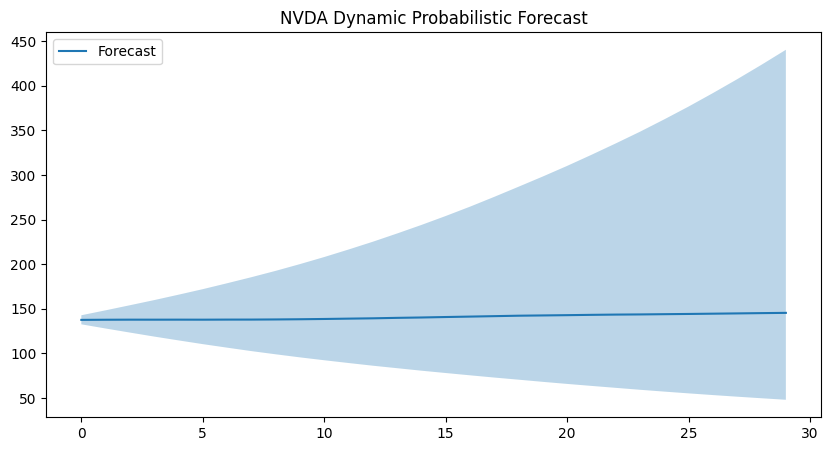

In [34]:
plt.figure(figsize=(10,5))
plt.plot(price_point, label="Forecast")
plt.fill_between(range(len(price_point)), price_lower, price_upper, alpha=0.3)
plt.title("NVDA Dynamic Probabilistic Forecast")
plt.legend()
plt.show()
